In [1]:
import os
import sys
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyemu
plt.rcParams['font.size']=12

In [2]:
workspace = "workspace"
model_name = "mf6model"
exe_name="mf6.exe"

nrow = 280
ncol = 240

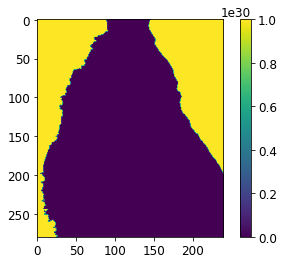

In [3]:
plt.imshow(fp.utils.HeadFile("workspace/{}.hds".format(model_name)).get_data((0,0))[0])
plt.colorbar()

In [4]:
sim = fp.mf6.MFSimulation.load(sim_ws=workspace)
m = sim.get_model(model_name)
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(workspace, "{}.nam".format(model_name)),
        delr=m.dis.delr.array, delc=m.dis.delc.array)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package riv...
    loading package obs...
    loading package oc...
  loading ims package mf6model...
   could not remove start_datetime


In [5]:
# empty pst from object
template_ws = "template"
pf = pyemu.utils.PstFrom(original_d=workspace, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

2020-12-29 21:26:07.797018 starting: opening PstFrom.log for logging
2020-12-29 21:26:07.798017 starting PstFrom process
2020-12-29 21:26:07.809010 starting: setting up dirs
2020-12-29 21:26:07.810011 starting: copying original_d 'workspace' to new_d 'template'
2020-12-29 21:26:08.053859 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:00.243848
2020-12-29 21:26:08.056857 finished: setting up dirs took: 0:00:00.247847


In [6]:
#add observation
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)

hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="hds",obsgp=False)

case = "pest_test"
pf.build_pst("{}.pst".format(case))

2020-12-29 21:26:08.104828 starting: adding observations from tabular output file
2020-12-29 21:26:08.106826 starting: reading list template\heads.csv
2020-12-29 21:26:08.119818 finished: reading list template\heads.csv took: 0:00:00.012992
2020-12-29 21:26:08.120817 starting: building insfile for tabular output file heads.csv
2020-12-29 21:26:08.252737 finished: building insfile for tabular output file heads.csv took: 0:00:00.131920
2020-12-29 21:26:08.254734 starting: adding observation from instruction file 'template\heads.csv.ins'
2020-12-29 21:26:08.314697 finished: adding observation from instruction file 'template\heads.csv.ins' took: 0:00:00.059963
2020-12-29 21:26:08.320693 finished: adding observations from tabular output file took: 0:00:00.215865
noptmax:30, npar_adj:0, nnz_obs:33


spatial variogram


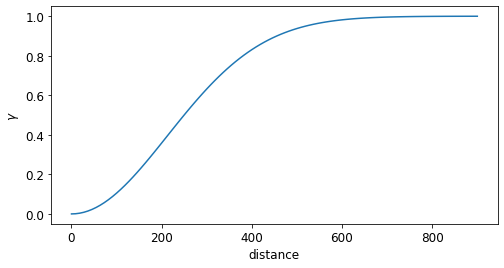

In [7]:
# a = ppspace*3.0
v = pyemu.geostats.GauVario(contribution=1.0,a=300)
grid_gs = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs.plot()
print("spatial variogram")

In [8]:
# set an homogeneous k array (as initial value)
k = 1e-4*np.ones([nrow,ncol])
filnm = "k.txt"
np.savetxt(os.path.join(template_ws,filnm),k)

In [9]:
pf.add_parameters(filenames="k.txt",par_type="pilotpoint",pp_space=100,
                   par_name_base="kp",pargp="hp",
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs)

2020-12-29 21:26:10.494191 starting: adding pilotpoint type multiplier style parameters for file(s) ['k.txt']
2020-12-29 21:26:10.494191 starting: loading array template\k.txt
2020-12-29 21:26:10.677077 finished: loading array template\k.txt took: 0:00:00.182886
2020-12-29 21:26:10.678078 loaded array 'k.txt' of shape (280, 240)
2020-12-29 21:26:10.842977 starting: writing array-based template file 'kp_inst0_pilotpoint.csv.tpl'
2020-12-29 21:26:10.843975 starting: setting up pilot point parameters
2020-12-29 21:26:10.843975 No spatial reference (containing cell spacing) passed.
2020-12-29 21:26:10.844977 OK - using spatial reference in parent object.
ibound not passed, using array of ones
2020-12-29 21:26:10.929923 4 pilot point parameters created
2020-12-29 21:26:10.929923 pilot point 'pargp':kp_inst:0
2020-12-29 21:26:10.930922 finished: setting up pilot point parameters took: 0:00:00.086947
2020-12-29 21:26:10.935917 starting: calculating factors for pargp=kp_inst:0
2020-12-29 21:26

C:\Users\Administrador\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


took 473.25227 seconds
2020-12-29 21:34:06.868915 finished: calculating factors for pargp=kp_inst:0 took: 0:07:55.932998
2020-12-29 21:34:06.869912 starting: writing array-based template file 'kp_inst0pp.dat.tpl'
2020-12-29 21:34:06.889898 finished: adding pilotpoint type multiplier style parameters for file(s) ['k.txt'] took: 0:07:56.395707


In [10]:
# add run model command
pf.mod_sys_cmds.append("..\mf6")
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:4, nnz_obs:33
2020-12-29 21:34:07.256395 forward_run line:pyemu.os_utils.run(r'..\mf6')



In [11]:
#Rewrite ins file because Pyemu isn't smart enough

file = "template/heads.csv.ins"
fileout = "template/heads2.csv.ins"
with open(file) as f:
    with open(fileout,"w") as fout:
        for i,line in enumerate(f):
            if i < 2:
                fout.write(line)
            if i > 1:
                for o,split in enumerate(line.split("w")):
                    if o == 1:
                        fout.write("~,~")
                    fout.write(split)
                        
from shutil import copyfile
copyfile(fileout, file) # copy 
os.remove(fileout) # delete tmp file

noptmax:30, npar_adj:4, nnz_obs:33
2020-12-29 21:34:07.564208 WARNING: sys_cmd 'pyemu.os_utils.run(r'..\mf6')
' already in sys cmds, skipping...
2020-12-29 21:34:07.595188 starting: building prior covariance matrix
2020-12-29 21:34:07.605181 saving prior covariance matrix to file template\pest_test.prior.cov
2020-12-29 21:34:07.612178 finished: building prior covariance matrix took: 0:00:00.016990


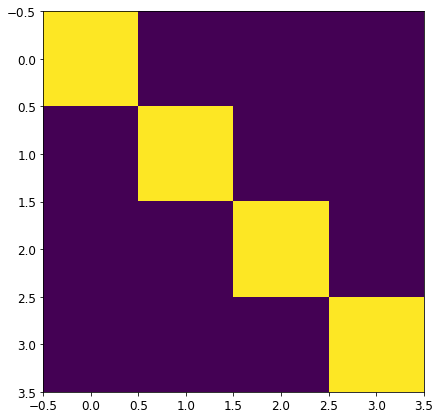

In [12]:
pst = pf.build_pst("{}.pst".format(case))
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(7,7))
g = ax.imshow(x)

In [13]:
t_d = "template"
m_d = "master_glm"

pst.control_data.noptmax = -1 # FOR JACOBIAN
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:-1, npar_adj:4, nnz_obs:33


In [14]:
# calculate
n = 4 #select number of workers
pyemu.os_utils.start_workers(t_d,"../pestpp-glm.exe","{}.pst".format(case),num_workers=n,worker_root=".",master_dir=m_d)

In [15]:
t_d ="master_glm"
case="pest_test"
pst = pyemu.Pst(os.path.join(t_d,"{}.pst".format(case)))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
kp_inst:0,kp_inst:0,log,4,0,1,-1,0.5


In [16]:
pyemu.helpers.zero_order_tikhonov(pst)
pst.control_data.pestmode = "regularization"
pst.control_data.noptmax = 9 
pst.pestpp_options["n_iter_base"] = -1 
pst.pestpp_options["n_iter_super"] = 4 
pst.pestpp_options["glm_num_reals"] = 50 
pst.pestpp_options["parcov"] = "{}.prior.cov".format(case) 
pst.pestpp_options["base_jacobian"] = "{}.jcb".format(case) 
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:9, npar_adj:4, nnz_obs:33


In [17]:
m_d = "master_glm_run"
pyemu.os_utils.start_workers(t_d,"../pestpp-glm","{}.pst".format(case),num_workers=n,worker_root=".",
                           master_dir=m_d)